# CS 5330
# Malhar Mahant & Kruthika Gangaraju & Sriram Kodeeswaran
# Final Project: Handwriting gesture detection and recognition

# Experiment with TrOCR model

In [ ]:
!pip install transformers
!pip install evaluate
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir IAMWords

mkdir: cannot create directory ‘IAMWords’: File exists


In [ ]:
!cd IAMWords && tar -zxf ../words.tgz

In [1]:
import os
import gc
import requests
import errno
import evaluate
import csv
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.optim import AdamW
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            # get file name + text 
            file_name = self.df['file_name'][idx]
            text = self.df['text'][idx]

            # prepare image (i.e. resize + normalize)
            image = Image.open(self.root_dir + file_name).convert("RGB")

            pixel_values = self.processor(image, return_tensors="pt").pixel_values
            # add labels (input_ids) by encoding the text
            labels = self.processor.tokenizer(text, 
                                              padding="max_length", 
                                              max_length=self.max_target_length).input_ids
            # important: make sure that PAD tokens are ignored by the loss function
            labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

            encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
            return encoding
        except:
            print(f"Error encountered: {file_name}")
            return None

def custom_collate(batch):
    "Puts each data field into a tensor with outer dimension batch size"
    batch = [x for x in batch if x is not None]
    return default_collate(batch)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
cer_metric = evaluate.load("cer")

# Helper to compute Character Error Rate given predictions and label ids
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

## Creating Easy to read Datasets from the IAM Handwritten Dataset

In [4]:
train_df = pd.read_csv('trainset.txt', header=None, sep='\t', quoting=csv.QUOTE_NONE)
train_df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
# train_df = train_df[:10000]
print(len(train_df))
train_df.head()

53841


,file_name,text
0,IAMWords/a01/a01-000u/a01-000u-00-00.png,A
1,IAMWords/a01/a01-000u/a01-000u-00-01.png,MOVE
2,IAMWords/a01/a01-000u/a01-000u-00-02.png,to
3,IAMWords/a01/a01-000u/a01-000u-00-03.png,stop
4,IAMWords/a01/a01-000u/a01-000u-00-04.png,Mr.


In [5]:
test_df = pd.read_csv('testset.txt', header=None, sep='\t', quoting=csv.QUOTE_NONE)
test_df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
# test_df = test_df[:10000]
print(len(test_df))
test_df.head()

17616


,file_name,text
0,IAMWords/m01/m01-049/m01-049-00-00.png,He
1,IAMWords/m01/m01-049/m01-049-00-01.png,rose
2,IAMWords/m01/m01-049/m01-049-00-02.png,from
3,IAMWords/m01/m01-049/m01-049-00-03.png,his
4,IAMWords/m01/m01-049/m01-049-00-04.png,breakfast-nook


In [6]:
valset_df = pd.read_csv('validationset1.txt', header=None, sep='\t', quoting=csv.QUOTE_NONE)
valset_df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
print(len(valset_df))
valset_df.head()

7899


,file_name,text
0,IAMWords/f04/f04-032/f04-032-00-00.png,They
1,IAMWords/f04/f04-032/f04-032-00-01.png,also
2,IAMWords/f04/f04-032/f04-032-00-02.png,had
3,IAMWords/f04/f04-032/f04-032-00-03.png,to
4,IAMWords/f04/f04-032/f04-032-00-04.png,cope


In [7]:
train_dataset = IAMDataset(root_dir='',
                           df=train_df,
                           processor=processor)
test_dataset = IAMDataset(root_dir='',
                           df=test_df,
                           processor=processor)
val_dataset = IAMDataset(root_dir='',
                           df=valset_df,
                           processor=processor)

In [8]:
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 53841
Number of test examples: 17616
Number of validation examples: 7899


In [9]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [10]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [11]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

A


In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=custom_collate, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=4, collate_fn=custom_collate)

## Load Pre-Trained DataModel

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [14]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

## Evaluating on test IAM data before training

In [15]:
model.eval()
valid_cer = 0.0
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer 

print("Validation CER:", valid_cer / len(test_dataloader))

  0%|          | 0/4404 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Error encountered: IAMWords/m02/m02-083/m02-083-11-08.png
Error encountered: IAMWords/m04/m04-030/m04-030-01-05.png
Error encountered: IAMWords/m04/m04-043/m04-043-00-06.png
Error encountered: IAMWords/m04/m04-043/m04-043-00-10.png
Error encountered: IAMWords/m04/m04-043/m04-043-01-06.png
Error encountered: IAMWords/m04/m04-043/m04-043-01-07.png
Error encountered: IAMWords/m04/m04-043/m04-043-01-12.png
Error encountered: IAMWords/m04/m04-081/m04-081-10-07.png
Error encountered: IAMWords/m04/m04-131/m04-131-07-09.png
Error encountered: IAMWords/m04/m04-138/m04-138-00-04.png
Error encountered: IAMWords/n01/n01-045/n01-045-03-07.png
Error encountered: IAMWords/n01/n01-045/n01-045-06-06.png
Error encountered: IAMWords/n02/n02-049/n02-049-01-04.png
Error encountered: IAMWords/n04/n04-052/n04-052-06-03.png
Error encountered: IAMWords/n04/n04-060/n04-060-02-02.png
Error encountered: IAMWords/n04/n04-075/n04-075-05-03.png
Error encountered: IAMWords/n04/n04-107/n04-107-06-10.png
Error encounte

torch.Size([1, 3, 384, 384])


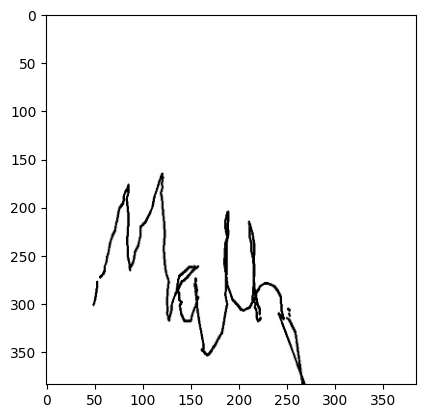

torch.Size([5])
['Maltz']


In [16]:
# get file name + text 
file_name = 'Malh.jpg'
# prepare image (i.e. resize + normalize)
image = Image.open(file_name).convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)
# Convert pixel_values to a NumPy array
pixel_values_np = pixel_values.squeeze().numpy()
pixel_values_np = pixel_values_np.transpose(1, 2, 0)
# Display the pixel values using matplotlib
plt.imshow(pixel_values_np)
plt.show()
pred = model.generate(pixel_values.to(device))
print(pred.squeeze().shape)
stri = processor.batch_decode(pred, skip_special_tokens=True)
print(stri)

## Training using IAM Dataset

In [17]:
gc.collect()
torch.cuda.empty_cache()  

In [18]:
optimizer = AdamW(model.parameters(), lr=5e-5)
val_length = 0
train_length = 0
epochs = 1
iters_to_accumulate = 4  # Number of steps to accumulate gradients
accumulator = 0
scaler = GradScaler()
for epoch in range(1):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        if epoch == 0:
            train_length += len(batch)
        # Method 1
        # # get the inputs
        #     for k,v in batch.items():
        #         batch[k] = v.to(device)
        #     # forward + backward + optimize
        #     outputs = model(**batch)
        #     loss = outputs.loss
        #     loss.backward()
        #     optimizer.step()
        #     optimizer.zero_grad()
        #     torch.cuda.empty_cache()
        # train_loss += loss.item()
        
        
        # Method 2
        with autocast(device_type="cuda", dtype=torch.float16):
            # get the inputs
            for k,v in batch.items():
                batch[k] = v.to(device)
            
            # forward + backward + optimize
            outputs = model(**batch)
            loss = outputs.loss
            loss = loss / iters_to_accumulate
        
        # Accumulates scaled gradients.
        scaler.scale(loss).backward()
        accumulator += 1
        # Perform optimizer step after accumulating gradients for a certain number of steps
        if accumulator == iters_to_accumulate:
            # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            torch.cuda.empty_cache()
            accumulator = 0
            with open('train_loss', 'a') as outfile:
              outfile.write(f'{train_loss/train_length}\n')
        train_loss += loss.item()
        
        del batch
        gc.collect()
        torch.cuda.empty_cache()        
        
    print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
    # evaluate
    model.eval()
    valid_cer = 0.0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            if epoch == 0:
                val_length += len(batch)
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer
            with open('validation_loss', 'a') as outfile:
              outfile.write(f'{valid_cer/val_length}\n')
    # print("Validation CER:", valid_cer / len(val_dataloader))

model.save_pretrained(f"iam_word_trained_{epochs}")

  0%|          | 0/13461 [00:00<?, ?it/s]

Error encountered: IAMWords/g06/g06-011g/g06-011g-02-13.png
Error encountered: IAMWords/g06/g06-031c/g06-031c-07-06.png
Error encountered: IAMWords/a01/a01-117/a01-117-05-02.png
Error encountered: IAMWords/a05/a05-121/a05-121-00-07.png
Error encountered: IAMWords/c04/c04-128/c04-128-07-14.png
Error encountered: IAMWords/f02/f02-040/f02-040-09-09.png
Error encountered: IAMWords/a01/a01-030/a01-030-01-04.png
Error encountered: IAMWords/a01/a01-053/a01-053-08-02.png
Error encountered: IAMWords/g06/g06-050m/g06-050m-03-05.png
Error encountered: IAMWords/r02/r02-137/r02-137-08-05.png
Error encountered: IAMWords/b04/b04-147/b04-147-00-06.png
Error encountered: IAMWords/a01/a01-053x/a01-053x-01-04.png
Error encountered: IAMWords/g06/g06-031l/g06-031l-06-12.png
Error encountered: IAMWords/c03/c03-000d/c03-000d-01-06.png
Error encountered: IAMWords/g06/g06-018m/g06-018m-07-10.png
Error encountered: IAMWords/b05/b05-055/b05-055-04-10.png
Error encountered: IAMWords/a02/a02-017/a02-017-03-02.png


  0%|          | 0/1975 [00:00<?, ?it/s]

Error encountered: IAMWords/f07/f07-096/f07-096-05-13.png
Error encountered: IAMWords/f07/f07-084b/f07-084b-00-04.png
Error encountered: IAMWords/g01/g01-083/g01-083-10-06.png
Error encountered: IAMWords/g03/g03-040/g03-040-02-01.png
Error encountered: IAMWords/g03/g03-064/g03-064-07-08.png


In [19]:
print("Train Loss:", train_loss/len(train_dataloader))

Train Loss: 0.17072804920690784


In [20]:
print("Validation CER:", valid_cer / len(val_dataloader))

Validation CER: 0.1897708857746666


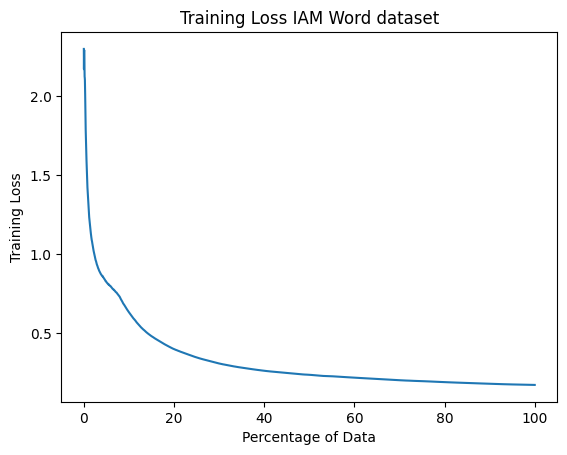

In [21]:
import matplotlib.pyplot as plt

# Read training loss values from file
with open('train_loss', 'r') as file:
    lines = file.readlines()[4:]
    training_losses = [float(line.strip())*2 for line in lines]

# Calculate percentage of data for each batch
batch_size = 4
total_samples = len(training_losses) * batch_size
percentage_of_data = [(i + 1) * batch_size / total_samples * 100 for i in range(len(training_losses))]

# Plot training losses against percentage of data
plt.plot(percentage_of_data, training_losses)
plt.xlabel('Percentage of Data')
plt.ylabel('Training Loss')
plt.title('Training Loss IAM Word dataset')
plt.savefig('Training Loss IAM Word dataset.png')
plt.show()


## If already trained load custom trained data model

In [4]:
#del model
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained("iam_word_trained_1")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [5]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

## Evaluating on test IAM data after training

In [68]:
model.eval()
valid_cer = 0.0
test_length = 0
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer 
        test_length += len(batch)

print("Validation CER:", valid_cer / len(test_dataloader))

  0%|          | 0/4404 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Error encountered: IAMWords/m02/m02-083/m02-083-11-08.png
Error encountered: IAMWords/m04/m04-030/m04-030-01-05.png
Error encountered: IAMWords/m04/m04-043/m04-043-00-06.png
Error encountered: IAMWords/m04/m04-043/m04-043-00-10.png
Error encountered: IAMWords/m04/m04-043/m04-043-01-06.png
Error encountered: IAMWords/m04/m04-043/m04-043-01-07.png
Error encountered: IAMWords/m04/m04-043/m04-043-01-12.png
Error encountered: IAMWords/m04/m04-081/m04-081-10-07.png
Error encountered: IAMWords/m04/m04-131/m04-131-07-09.png
Error encountered: IAMWords/m04/m04-138/m04-138-00-04.png
Error encountered: IAMWords/n01/n01-045/n01-045-03-07.png
Error encountered: IAMWords/n01/n01-045/n01-045-06-06.png
Error encountered: IAMWords/n02/n02-049/n02-049-01-04.png
Error encountered: IAMWords/n04/n04-052/n04-052-06-03.png
Error encountered: IAMWords/n04/n04-060/n04-060-02-02.png
Error encountered: IAMWords/n04/n04-075/n04-075-05-03.png
Error encountered: IAMWords/n04/n04-107/n04-107-06-10.png
Error encounte

torch.Size([1, 3, 384, 384])


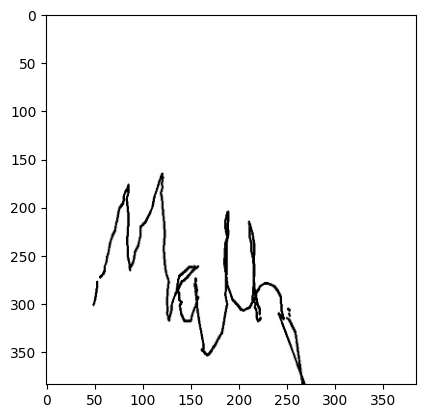

torch.Size([5])
['Mark-']


In [22]:
# get file name + text 
file_name = 'Malh.jpg'
# prepare image (i.e. resize + normalize)
image = Image.open(file_name).convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)
# Convert pixel_values to a NumPy array
pixel_values_np = pixel_values.squeeze().numpy()
pixel_values_np = pixel_values_np.transpose(1, 2, 0)
# Display the pixel values using matplotlib
plt.imshow(pixel_values_np)
plt.show()
pred = model.generate(pixel_values.to(device))
print(pred.squeeze().shape)
stri = processor.batch_decode(pred, skip_special_tokens=True)
print(stri)

## Create Datasets from Custom Handwritten Data

In [18]:
!unzip custom_digital_handwritten_data.zip

Archive:  custom_digital_handwritten_data.zip
replace custom_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [19]:
df = pd.read_csv('custom_data.csv', header=None, quoting=csv.QUOTE_NONE)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
print(len(df))
df.head()

481


,file_name,text
0,data/A.jpg,A
1,data/A_1.jpg,A
2,data/A_2.jpg,A
3,data/A_3.jpg,A
4,data/A_4.jpg,A


In [37]:
custom_train_df, custom_test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
custom_train_df.reset_index(drop=True, inplace=True)
custom_test_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [38]:
custom_train_dataset = IAMDataset(root_dir='',
                           df=custom_train_df,
                           processor=processor)
custom_test_dataset = IAMDataset(root_dir='',
                           df=custom_test_df,
                           processor=processor)
custom_dataset = IAMDataset(root_dir='',
                           df=df,
                           processor=processor)

In [39]:
print("Number of training examples:", len(custom_train_dataset))
print("Number of validation examples:", len(custom_test_dataset))
print("Total Number of examples:", len(custom_dataset))

Number of training examples: 384
Number of validation examples: 97
Total Number of examples: 481


In [40]:
encoding = custom_train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


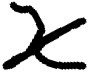

In [41]:
image = Image.open(custom_train_dataset.root_dir + custom_train_df['file_name'][0]).convert("RGB")
image

In [25]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

2


In [26]:
custom_train_dataloader = DataLoader(custom_train_dataset, batch_size=4, collate_fn=custom_collate, shuffle=True)
custom_test_dataloader = DataLoader(custom_test_dataset, batch_size=4, collate_fn=custom_collate)
custom_dataloader = DataLoader(custom_dataset, batch_size=4, collate_fn=custom_collate)

## Test custom dataset before training

In [16]:
model.eval()
valid_cer = 0.0
with torch.no_grad():
    for batch in tqdm(custom_test_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer

print("Test CER:", valid_cer / len(custom_test_dataloader))

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Test CER: 1.492


In [17]:
model.eval()
valid_cer = 0.0
with torch.no_grad():
    for batch in tqdm(custom_test_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer
    for batch in tqdm(custom_train_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer

print("Test CER:", valid_cer / len(custom_dataset))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Test CER: 0.3644705144705145


## Training using custom dataset

In [27]:
gc.collect()
torch.cuda.empty_cache()  

In [28]:
optimizer = AdamW(model.parameters(), lr=5e-5)
val_length = 0
train_length = 0
epochs = 30
iters_to_accumulate = 4  # Number of steps to accumulate gradients
accumulator = 0
scaler = GradScaler()
for epoch in range(epochs):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(custom_train_dataloader):
        if epoch == 0:
            train_length += len(batch)
        # Method 1
        # # get the inputs
        #     for k,v in batch.items():
        #         batch[k] = v.to(device)
        #     # forward + backward + optimize
        #     outputs = model(**batch)
        #     loss = outputs.loss
        #     loss.backward()
        #     optimizer.step()
        #     optimizer.zero_grad()
        #     torch.cuda.empty_cache()
        # train_loss += loss.item()
        
        
        # Method 2
        with autocast(device_type="cuda", dtype=torch.float16):
            # get the inputs
            for k,v in batch.items():
                batch[k] = v.to(device)
            
            # forward + backward + optimize
            outputs = model(**batch)
            loss = outputs.loss
            loss = loss / iters_to_accumulate
        
        # Accumulates scaled gradients.
        scaler.scale(loss).backward()
        accumulator += 1
        # Perform optimizer step after accumulating gradients for a certain number of steps
        if accumulator == iters_to_accumulate:
            # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            torch.cuda.empty_cache()
            accumulator = 0
        train_loss += loss.item()
        
        del batch
        gc.collect()
        torch.cuda.empty_cache()        
        
    print(f"Loss after epoch {epoch}:", train_loss/len(custom_train_dataloader))
    with open('custom_train_loss', 'a') as outfile:
        outfile.write(f'{train_loss/len(custom_train_dataloader)}\n')
    # evaluate
    model.eval()
    valid_cer = 0.0
    with torch.no_grad():
        for batch in tqdm(custom_test_dataloader):
            if epoch == 0:
                val_length += len(batch)
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer
    print("Validation CER:", valid_cer / len(custom_test_dataloader))
    with open('custom_validation_loss', 'a') as outfile:
        outfile.write(f'{valid_cer/len(custom_test_dataloader)}\n')
model.save_pretrained(f"custom_trained_{epochs}")

  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 0: 0.17597591652884148


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Validation CER: 0.4288571428571429


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 1: 0.04904268993050209


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.1997142857142857


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 2: 0.029068098271485116


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.25142857142857145


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 3: 0.013383855019280114


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.16057142857142856


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 4: 0.01452732292299667


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.20928571428571427


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 5: 0.010396672039272895


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.20542857142857143


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 6: 0.01158610948630212


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.2674285714285714


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 7: 0.007984935174969602


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.18771428571428572


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 8: 0.005524045319935074


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.21200000000000002


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 9: 0.007023937109295275


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.19200000000000003


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 10: 0.018300759203233003


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.18128571428571427


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 11: 0.006237056416930879


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.31


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 12: 0.013766111785538252


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.2602857142857143


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 13: 0.01337077204234068


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.12400000000000003


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 14: 0.009156672167838073


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.179


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 15: 0.0069814236220366865


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.28400000000000003


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 16: 0.009686707448594234


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.24728571428571428


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 17: 0.005797406067538684


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.2007142857142857


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 18: 0.005880134654630591


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.21200000000000002


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 19: 0.005891347540530963


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.20128571428571426


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 20: 0.002336713455356687


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.19628571428571429


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 21: 0.005579354562541994


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.1912857142857143


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 22: 0.0020658984055614837


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.15128571428571427


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 23: 0.0004399430787553153


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.15128571428571427


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 24: 0.00016428700267212548


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.16628571428571426


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 25: 3.713273050761264e-05


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.1482857142857143


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 26: 2.800897307035181e-05


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.1482857142857143


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 27: 2.2254971847009603e-05


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.1482857142857143


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 28: 2.0503775065942403e-05


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.1482857142857143


  0%|          | 0/96 [00:00<?, ?it/s]

Loss after epoch 29: 1.8096349829003582e-05


  0%|          | 0/25 [00:00<?, ?it/s]

Validation CER: 0.1482857142857143


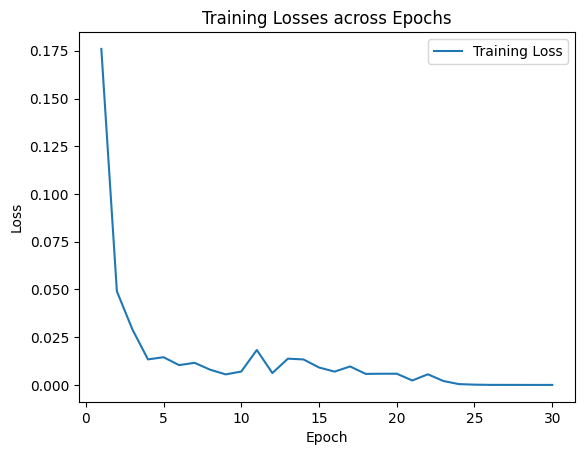

In [29]:
# Read training loss values
with open('custom_train_loss', 'r') as train_file:
    train_lines = train_file.readlines()
    train_losses = [float(line.strip()) for line in train_lines]

# Create list of epochs
epochs = list(range(1, len(train_losses) + 1))

# Plot training losses
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses across Epochs')
plt.savefig('Training Loss Custom dataset.png')
plt.show()


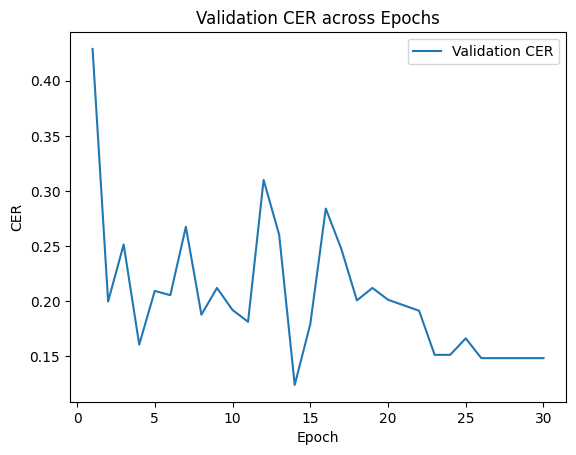

In [30]:
# Read validation CER values
with open('custom_validation_loss', 'r') as val_file:
    val_lines = val_file.readlines()
    val_losses = [float(line.strip()) for line in val_lines]

# Create list of epochs
epochs = list(range(1, len(train_losses) + 1))

# Plot validation CER 
plt.plot(epochs, val_losses, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.legend()
plt.title('Validation CER across Epochs')
plt.savefig('Validation CER Custom dataset.png')
plt.show()


## Load custom trained model

In [33]:
del model
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained("custom_trained_30")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [34]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

## Test custom dataset after training

In [35]:
model.eval()
valid_cer = 0.0
with torch.no_grad():
    for batch in tqdm(custom_test_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer

print("Test CER:", valid_cer / len(custom_test_dataloader))

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Test CER: 0.1482857142857143


In [36]:
model.eval()
valid_cer = 0.0
with torch.no_grad():
    for batch in tqdm(custom_test_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer
    for batch in tqdm(custom_train_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer

print("Custom Dataset CER:", valid_cer / len(custom_train_dataloader))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Custom Dataset CER: 0.03861607142857143


## Colab Helper Code

In [ ]:
from google.colab import files
files.download('iam_word_trained_1/config.json')
files.download('iam_word_trained_1/generation_config.json')
# files.download('iam_word_trained_1/pytorch_model.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# Specify the file path
file_path = "iam_word_trained_after/pytorch_model.bin"

# Start a new upload session
url_start = "https://content.dropboxapi.com/2/files/upload_session/start"
headers_start = {
    'Authorization': 'Bearer null',
    'Content-Type': 'application/octet-stream',
    'Dropbox-API-Arg': '{}'
}
response_start = requests.post(url_start, headers=headers_start)

# Extract the session ID from the response
session_id = response_start.json()['session_id']
print(session_id)
# Upload the file in chunks
chunk_size = 4 * 1024 * 1024  # 4 MB, must be a multiple of 4194304 bytes
offset = 0
url_append = "https://content.dropboxapi.com/2/files/upload_session/append_v2"
while True:
    with open(file_path, 'rb') as file:
        file.seek(offset)
        chunk = file.read(chunk_size)
        if not chunk:
            break
        headers_append = {
            'Authorization': 'Bearer null',
            'Content-Type': 'application/octet-stream',
            'Dropbox-API-Arg': '{"cursor":{"session_id":"' + session_id + '","offset":' + str(offset) + '}}'
        }
        response_append = requests.post(url_append, headers=headers_append, data=chunk)
        offset += len(chunk)
print(offset)
# Finish the upload session
url_finish = "https://content.dropboxapi.com/2/files/upload_session/finish"
headers_finish = {
    'Authorization': 'Bearer null',
    'Content-Type': 'application/octet-stream',
    'Dropbox-API-Arg': '{"cursor":{"session_id":"' + session_id + '","offset":' + str(offset) + '},"commit":{"path":"/pytorch_model.bin"}}'
}
response_finish = requests.post(url_finish, headers=headers_finish)

# Print the response data
print(response_finish.json())


pid_upload_session:ABIGRB86OZFXfaqSTW7cH7W3i45vjPHsE8Tt0Trg96IGfVHoDw
1335854221
{'name': 'pytorch_model.bin', 'path_lower': '/pytorch_model.bin', 'path_display': '/pytorch_model.bin', 'id': 'id:t8oF3ELJ4dIAAAAAAAAACg', 'client_modified': '2023-04-26T09:18:48Z', 'server_modified': '2023-04-26T09:18:48Z', 'rev': '5fa39ba440b41edb6a921', 'size': 1335854221, 'is_downloadable': True, 'content_hash': 'dbc75e7d3248f0159690c06f2970753c30f485e3d3167dd6a6f7b1ccba24feba'}
